In [1]:
import pandas as pd
import numpy as np
import shap
import warnings
import joblib
import sys
import psutil
import GPUtil
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, GroupKFold
from collections import defaultdict
from time import time
from datetime import timedelta
from importlib.metadata import version

# printout of python version
print("="*50, "Python Version", "="*50)
print(f"python version: {sys.version}")
print(f"xgboost:        {version('xgboost')}")
print(f"shap:           {version('shap')}")

# printout of hardware
print("="*50, "Hardware", "="*50)
gpus = GPUtil.getGPUs()
for gpu in gpus:
    print(f"GPU: {gpu.name}")
print(f"CPU cores: {psutil.cpu_count(logical=False)}")
print(f"RAM: {psutil.virtual_memory().total / 1024 / 1024 / 1024 :.2f} GB")

warnings.filterwarnings('ignore')

================================================== Python Version ==================================================
python version: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
xgboost:        2.1.1
shap:           0.46.0
================================================== Hardware ==================================================
GPU: NVIDIA GeForce RTX 4090
CPU cores: 16
RAM: 63.82 GB


# read data function

In [2]:
def read_abcd(path, cols, na_values):
    
    df = pd.read_csv(path, sep='\t', index_col='subjectkey', na_values=na_values)
    df = df.drop(df.index[0])
    
    for col in cols:
        df[col] = pd.to_numeric(df[col])
        df = df[cols]

    df = df.reset_index()
    df = df.sort_values(['subjectkey', 'interview_age'])
    df = df.drop_duplicates(subset=['subjectkey'], keep='first')
    df = df.drop(columns=['interview_age'])
    df = df.set_index('subjectkey')
    
    df_show = abcd_ysu02.join(df)
    df_show = df_show.drop(columns=[
        'isip_1d_2',
        'isip_5_2',
        'isip_1b_yn'
    ])
     
    for col in df_show.columns:
        print('{:<30}    n = {:<10}    mean = {:<10.4f}    sum = {:<10.1f}'.\
              format(col,  df_show[col].notnull().sum(), df_show[col].mean(), df_show[col].sum()))    
    print('\nsubjects:{:>10}\nfeatures:{:>10}'.format(df_show.shape[0], df_show.shape[1]))
    
    return df

# y-target variable

In [3]:
file_abcd_ysu02 = r'D:\gregn\data\ABCD\abcd3\abcd_ysu02.txt'
abcd_ysu02 = pd.read_csv(file_abcd_ysu02, sep='\t', index_col='subjectkey')
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02.index[0])
cols = [
    'interview_age',
    'isip_1d_2',
    'isip_5_2',
    'isip_1b_yn'
]

for col in cols:
    abcd_ysu02[col] = pd.to_numeric(abcd_ysu02[col])
    abcd_ysu02 = abcd_ysu02[cols]
    
abcd_ysu02 = abcd_ysu02.reset_index()
abcd_ysu02 = abcd_ysu02.sort_values(['subjectkey', 'interview_age'])
abcd_ysu02 = abcd_ysu02.drop_duplicates(subset=['subjectkey'], keep='first')
abcd_ysu02 = abcd_ysu02.drop(columns=['interview_age'])
abcd_ysu02 = abcd_ysu02.set_index('subjectkey')
    
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02[abcd_ysu02.isip_5_2 == 3].index) # drop accidental 
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02[abcd_ysu02.isip_5_2 == 2].index) # drop furtive 
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02[abcd_ysu02.isip_1b_yn == 0].index) # drop religious 
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02[abcd_ysu02.isip_1d_2 > 10].index) # drop older than 10

abcd_ysu02['isip_1d_2'] = abcd_ysu02['isip_1d_2'].fillna(0)

y = abcd_ysu02['isip_1d_2'].values
y = np.where(y>0, 1, y)

unique, counts = np.unique(y, return_counts=True)

print('number of subjects: {:>10}\n\n[0] never sipped: {:>12}\n[1] sipped by age 10:{:>9}'.\
      format(len(y), counts[0], counts[1]))

number of subjects:      10707

[0] never sipped:         9209
[1] sipped by age 10:     1498


# acspsw03

In [4]:
path = r'D:\gregn\data\ABCD\abcd3\acspsw03.txt'

cols = [
    'interview_age',
    'rel_family_id',
    'acs_raked_propensity_score'
]

na_values = [None]
acspsw03 = read_abcd(path, cols, na_values)
acspsw03 = acspsw03.drop(columns='acs_raked_propensity_score')

rel_family_id                     n = 10707         mean = 5921.1416     sum = 63397663.0
acs_raked_propensity_score        n = 10707         mean = 690.4637      sum = 7392794.6 

subjects:     10707
features:         2


# load X feature datasets

In [5]:
env = pd.read_csv(r'C:\Users\gregn\jupyter\ABCD_sipping_paper\environmental\X_features_environmental.csv')
psych = pd.read_csv(r'C:\Users\gregn\jupyter\ABCD_sipping_paper\psychological\X_features_psychological.csv')
health = pd.read_csv(r'C:\Users\gregn\jupyter\ABCD_sipping_paper\health\X_features_health.csv')

X = pd.merge(env, psych, on='subjectkey', how='left')
X = pd.merge(X, health, on='subjectkey', how='left')
X = pd.merge(X, acspsw03, on='subjectkey', how='left')
X = X.drop(columns='subjectkey')

# family groups

In [6]:
d = defaultdict(lambda: len(d))
family_groups = [d[x] for x in X['rel_family_id']]
family_groups = np.array(family_groups)
print(f"there are {len(np.unique(family_groups))} unique family groups")

there are 9011 unique family groups


# X features 

In [7]:
# drop family id that was merged 
X = X.drop(columns='rel_family_id')
X_values = X.values

print('number of features:', X.shape[1])
list(X.columns)

number of features: 827


['asr_scr_perstr_t',
 'asr_scr_anxdep_t',
 'asr_scr_withdrawn_t',
 'asr_scr_somatic_t',
 'asr_scr_thought_t',
 'asr_scr_attention_t',
 'asr_scr_aggressive_t',
 'asr_scr_rulebreak_t',
 'asr_scr_intrusive_t',
 'asr_scr_internal_t',
 'asr_scr_external_t',
 'asr_scr_totprob_t',
 'asr_scr_depress_t',
 'asr_scr_anxdisord_t',
 'asr_scr_somaticpr_t',
 'asr_scr_avoidant_t',
 'asr_scr_adhd_t',
 'asr_scr_antisocial_t',
 'asr_scr_inattention_t',
 'asr_scr_hyperactive_t',
 'reshist_addr1_years',
 'reshist_addr1_elevation',
 'reshist_addr1_d1a',
 'reshist_addr1_walkindex',
 'reshist_addr1_grndtot',
 'reshist_addr1_p1tot',
 'reshist_addr1_p1vlnt',
 'reshist_addr1_drugtot',
 'reshist_addr1_drgsale',
 'reshist_addr1_mjsale',
 'reshist_addr1_drgposs',
 'reshist_addr1_dui',
 'reshist_addr1_adi_edu_l',
 'reshist_addr1_adi_edu_h',
 'reshist_addr1_adi_work_c',
 'reshist_addr1_adi_income',
 'reshist_addr1_adi_in_dis',
 'reshist_addr1_adi_home_v',
 'reshist_addr1_adi_rent',
 'reshist_addr1_adi_mortg',
 'reshi

# XGBoost: 5x5 nested cross validation

In [8]:
start_time = time()

model = XGBClassifier(
    tree_method = 'gpu_hist',
    objective = 'binary:logistic',
    eval_metric = 'auc',
    random_state = 42, 
)

# hyperparameter grid
params = {
    'learning_rate': [0.005, 0.01, 0.1],
    'max_depth': [4, 6, 8],
    'n_estimators': [100, 500, 1000, 1500, 2000, 2500],
    'colsample_bytree': [0.4, 0.8]
}

# inner loop 
inner_cv = GroupKFold(n_splits=5)
inner_cv = inner_cv.get_n_splits(X_values, y, groups=family_groups)

# outer loop
outer_cv = GroupKFold(n_splits=5)
outer_cv = outer_cv.get_n_splits(X_values, y, groups=family_groups)
  
# inner loop grid search
gs = GridSearchCV(
    estimator=model, 
    param_grid=params, 
    scoring='roc_auc', 
    cv=inner_cv,
    return_train_score=True,
    verbose=3
)
gs.fit(X_values, y)

# multiple metrics 
scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']

# outer loop scores 
nested_scores = cross_validate(
    gs,
    X=X_values, 
    y=y, 
    scoring=scoring, 
    cv=outer_cv,
)

auc = nested_scores['test_roc_auc']
acc = nested_scores['test_accuracy']
precision = nested_scores['test_precision']
recall = nested_scores['test_recall']
f1 = nested_scores['test_f1']
print('='*120)
print('\nRuntime:', str(timedelta(seconds=time()-start_time)))
print()
print(f'Average ROC AUC score:      {auc.mean():.4f} {auc}')
print(f'Average accuracy score:     {acc.mean():.4f} {acc}')
print(f'Average precision score:    {precision.mean():.4f} {precision}')
print(f'Average recall score:       {recall.mean():.4f} {recall}')
print(f'Average F1 score:           {f1.mean():.4f} {f1}')
print('\nBest parameters:\n', gs.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.811, test=0.755) total time=   0.6s
[CV 2/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.808, test=0.754) total time=   0.4s
[CV 3/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.807, test=0.737) total time=   0.4s
[CV 4/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.812, test=0.728) total time=   0.4s
[CV 5/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.810, test=0.744) total time=   0.4s
[CV 1/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=500;, score=(train=0.853, test=0.765) total time=   1.2s
[CV 2/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=500;, score=(train=0.

In [9]:
joblib.dump(gs, 'combined_gridsearch.pkl')
joblib.dump(nested_scores, 'combined_nested_scores.pkl')

['combined_nested_scores.pkl']

# SHAP (SHapley Additive exPlanations)

In [10]:
explainer = shap.Explainer(gs.best_estimator_)
shap_values = explainer(X)

# SHAP ranking of top model features

In [11]:
# Create SHAP ranking dataframe
sv_mean = np.abs(shap_values.values).mean(0)
sv_rank = pd.DataFrame(list(zip(X, sv_mean)), columns=['feature', 'mean absolute SHAP value'])
sv_rank = sv_rank.sort_values(by='mean absolute SHAP value', ascending=False)
sv_rank['percent importance'] = sv_rank['mean absolute SHAP value'] / sv_rank['mean absolute SHAP value'].sum()*100
sv_rank['cumulative importance (%)'] = sv_rank['percent importance'].cumsum()
sv_rank.reset_index(inplace=True, drop=True)

print(f"Sum of SHAP values: {sv_rank['mean absolute SHAP value'].sum()}")
sv_rank[:60]

Sum of SHAP values: 3.1259260177612305


feature  mean absolute SHAP value  \
0                               su_risk_p_1                  0.233450   
1                          site_id_l_site16                  0.151355   
2                               macv_p_ss_r                  0.139305   
3                      parent_rules_q1a_3.0                  0.077303   
4   meim_ethnic_id_p_black/african_american                  0.069535   
5                               pds_skin2_y                  0.060457   
6                       parent_rules_q1_1.0                  0.057828   
7                   pps_y_ss_severity_score                  0.054414   
8               upps_y_ss_sensation_seeking                  0.052730   
9                   reshist_addr1_adi_edu_h                  0.051867   
10                          demo_prnt_ed_v2                  0.050520   
11                         stq_y_ss_weekend                  0.043143   
12                                bisbas1_y                  0.040699   
13                                 upps28_y                  0.038884   
14                               devhx_18_p                  0.037555   
15                                 upps12_y                  0.035211   
16                                 upps27_y                  0.034643   
17                      pps_y_ss_bother_sum                  0.033487   
18                      demo_comb_income_v2                  0.030166   
19                              school_15_y                  0.030061   
20               upps_y_ss_negative_urgency                  0.029077   
21                          ravlt_immediate                  0.028897   
22                 devhx_ss_8_alcohol_max_p                  0.028289   
23                        asr_scr_somatic_t                  0.027677   
24                               school_3_y                  0.027437   
25                              via_p_ss_hc                  0.026446   
26                           ksads_23_956_t                  0.025785   
27                          pps_y_ss_number                  0.025470   
28             devhx_ss_8_alcohol_effects_p                  0.025197   
29                  reshist_addr1_adi_edu_l                  0.025017   
30                    reshist_addr1_drgsale                  0.024548   
31                  parent_rules_q1_allowed                  0.024055   
32               upps_y_ss_lack_of_planning                  0.023598   
33                           ksads_23_957_t                  0.022890   
34                   reshist_addr1_adi_b138                  0.022755   
35           reshist_addr1_leadrisk_housing                  0.019963   
36                          sleepdisturb1_p                  0.019905   
37                          crpbi_parent3_y                  0.019897   
38                 reshist_addr1_adi_income                  0.019482   
39                             macv_p_ss_fo                  0.018597   
40                  reshist_addr1_elevation                  0.017955   
41                          bis_y_ss_bas_fs                  0.017781   
42                  reshist_addr1_adi_crowd                  0.017631   
43                               school_8_y                  0.017556   
44                            macv_p_ss_isr                  0.017454   
45                                 upps20_y                  0.017440   
46                         anthroheightcalc                  0.016987   
47                 devhx_ss_8_alcohol_avg_p                  0.016909   
48                  reshist_addr1_adi_unemp                  0.014199   
49                 reshist_addr1_pm252016aa                  0.014138   
50                           ksads_23_958_t                  0.014019   
51                      parent_rules_q8_3.0                  0.013283   
52                 reshist_addr1_adi_home_v                  0.013205   
53                            sds_p_ss_does                  0.013127   
54                   

# SHAP summary plot of top features

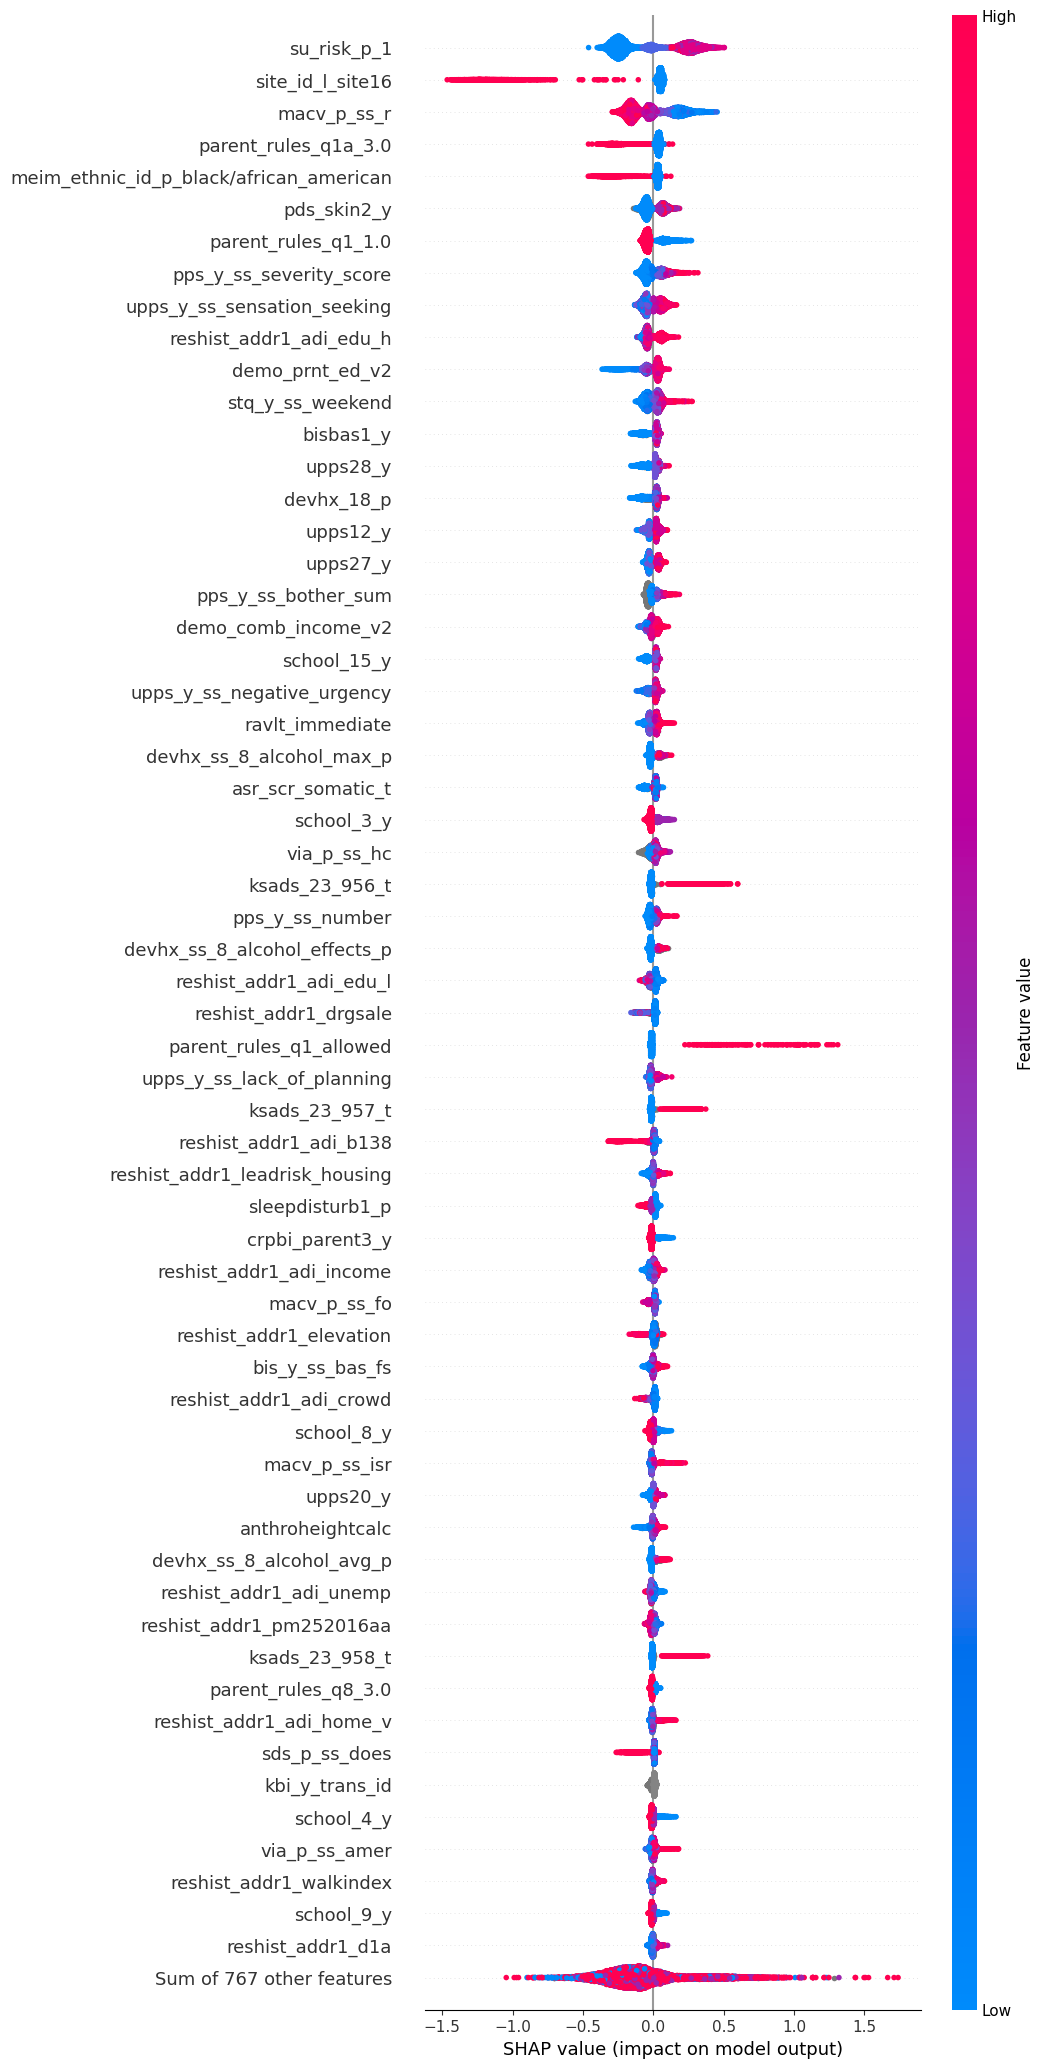

In [12]:
shap.plots.beeswarm(shap_values, max_display=61)

# SHAP dependence plots

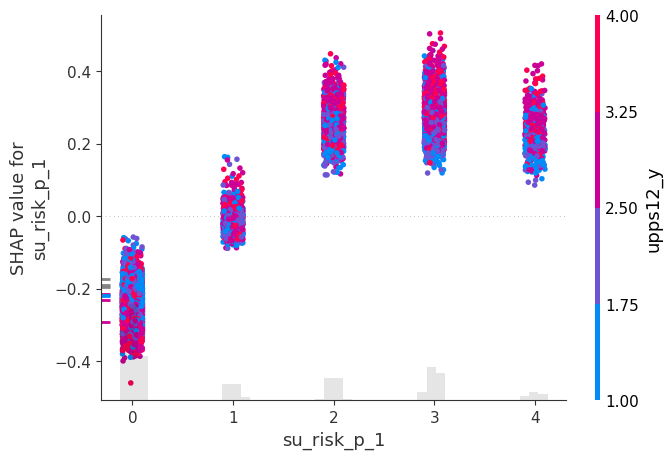

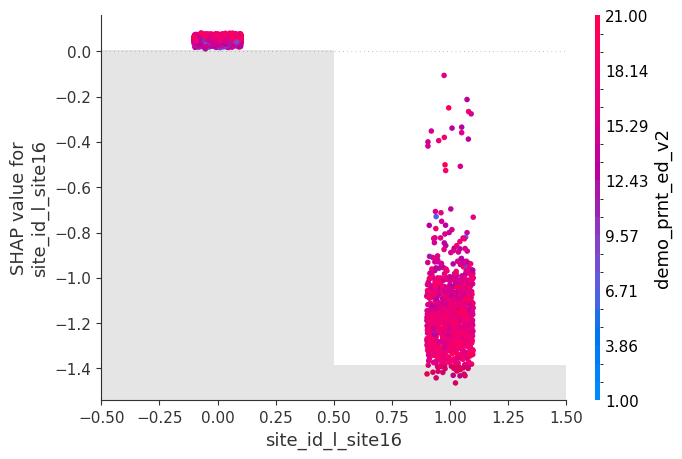

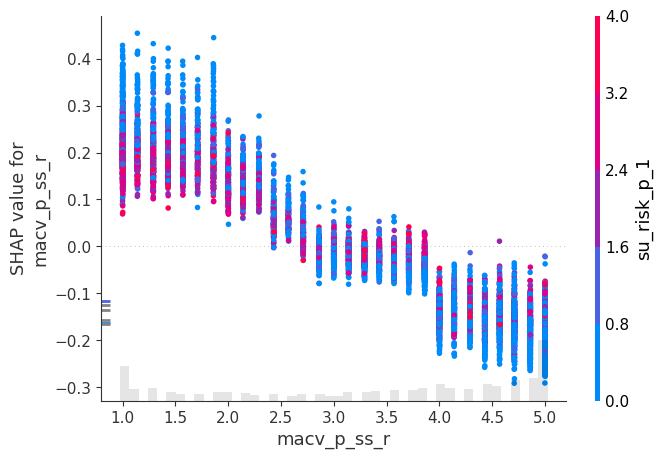

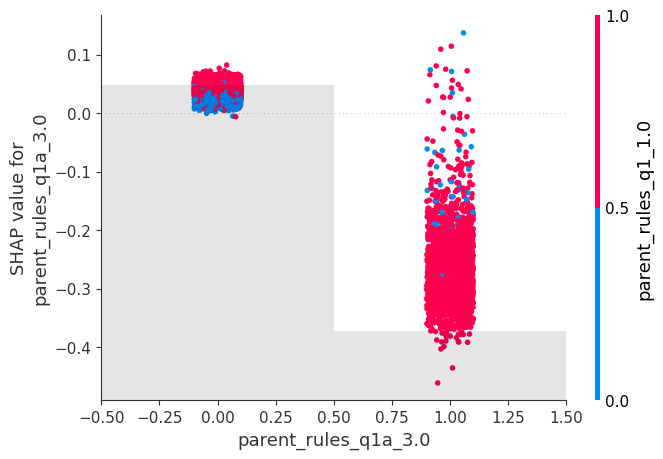

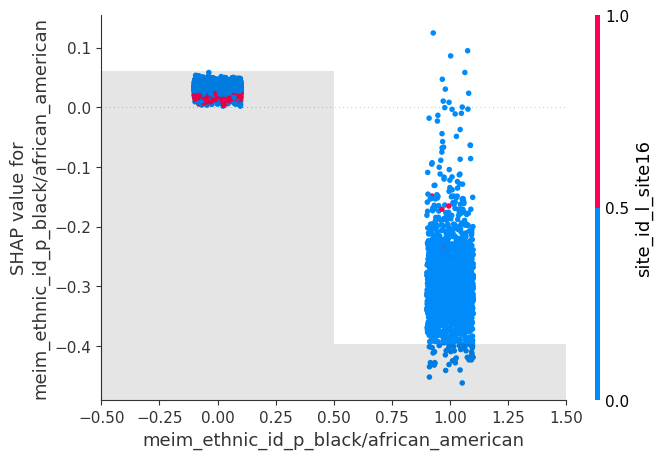

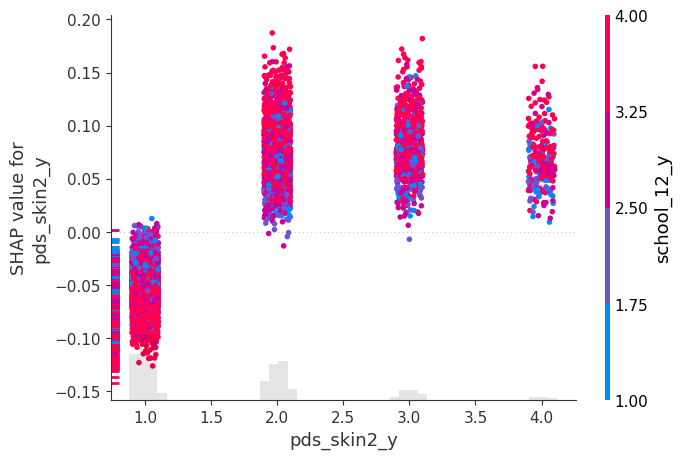

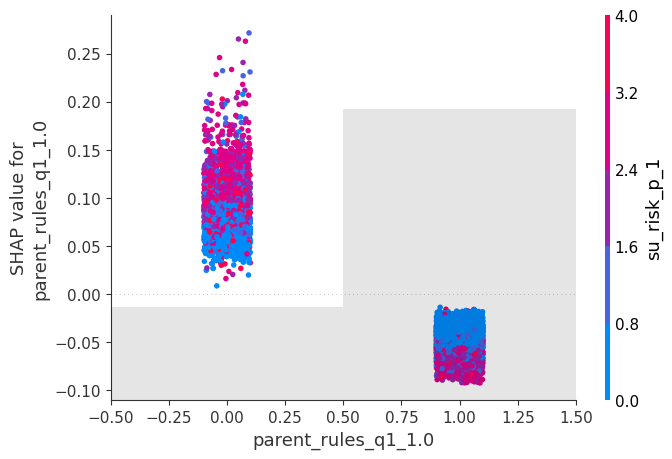

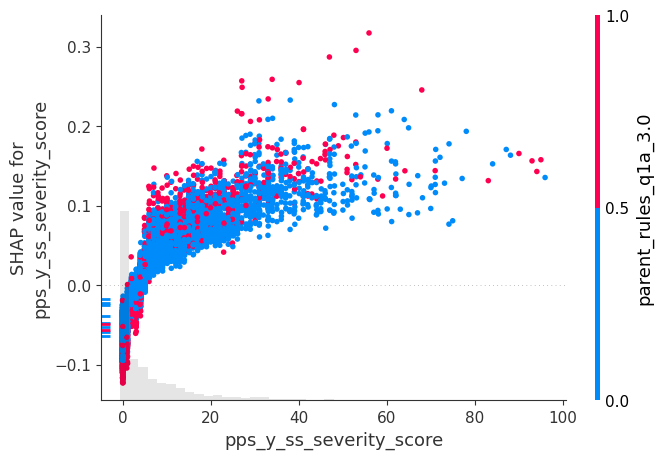

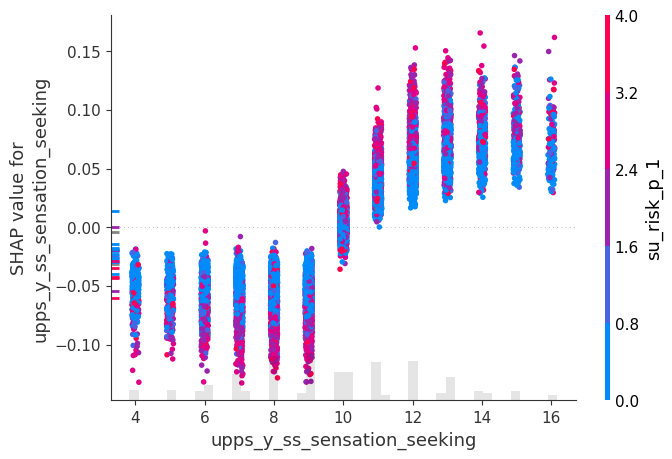

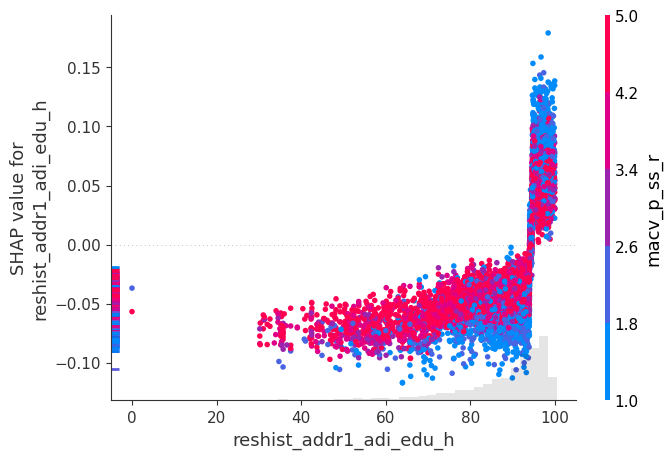

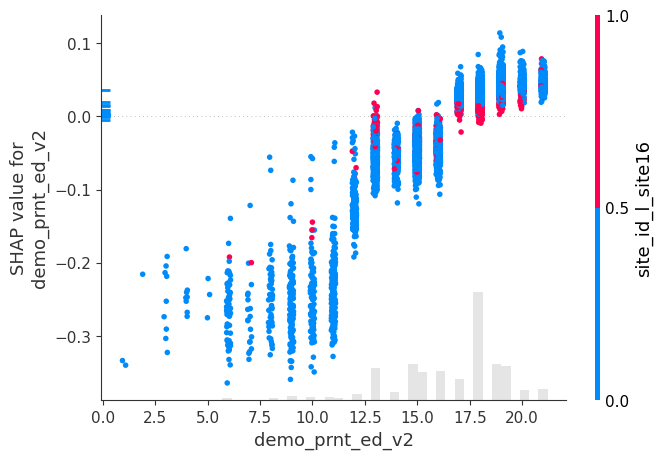

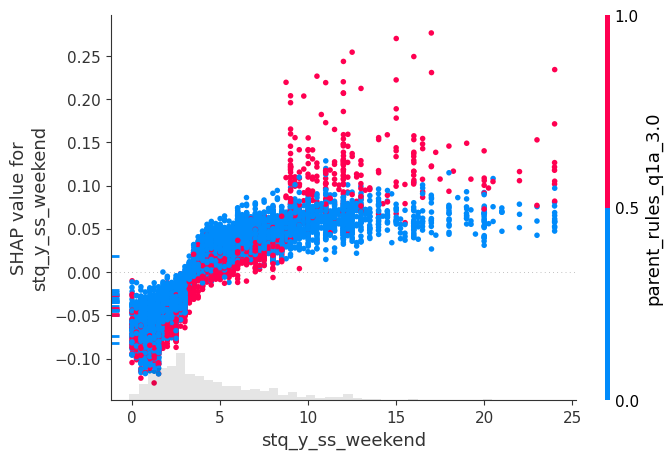

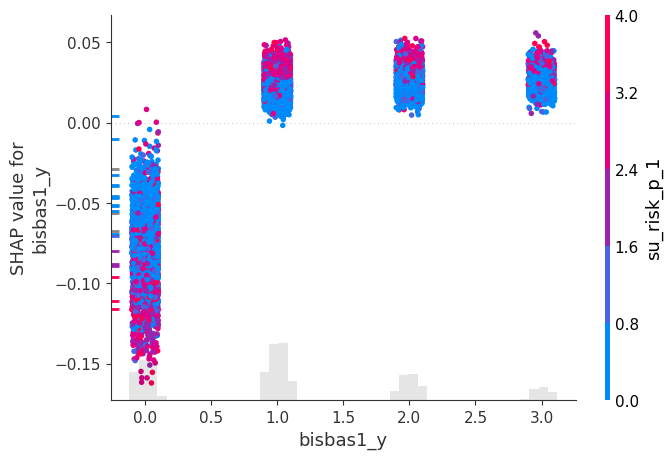

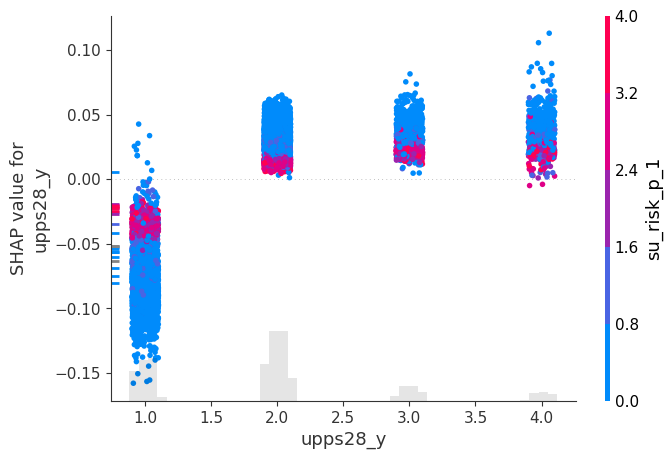

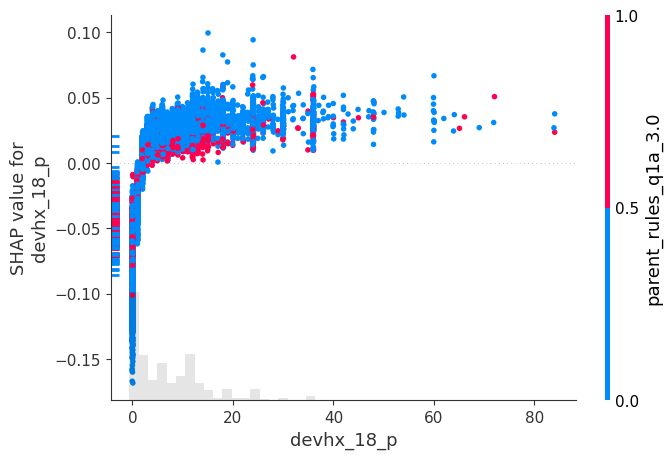

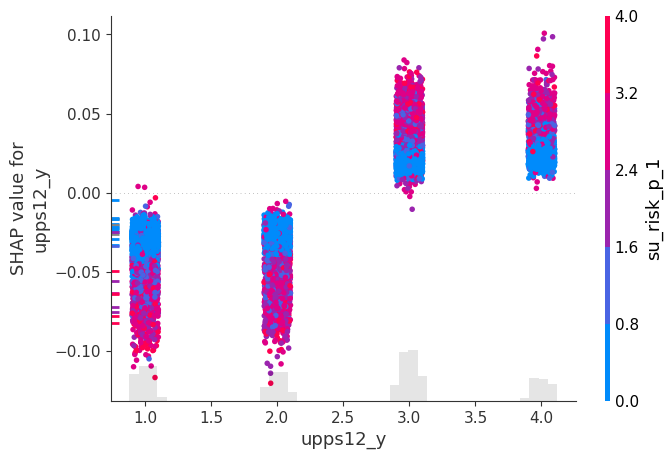

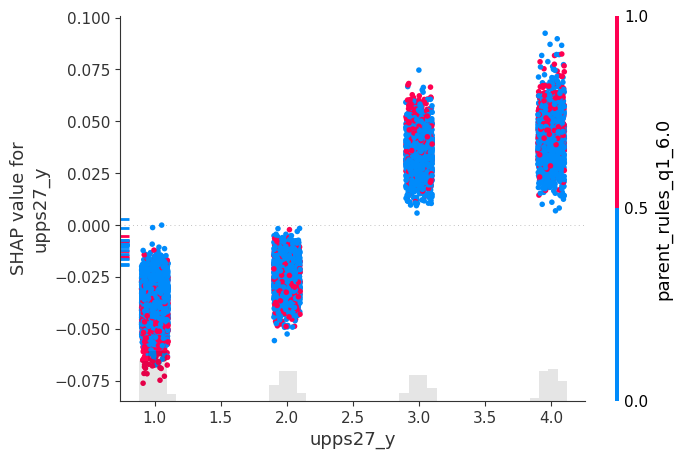

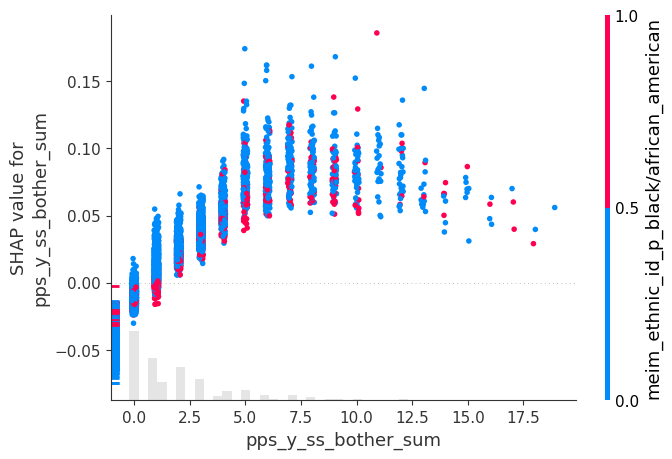

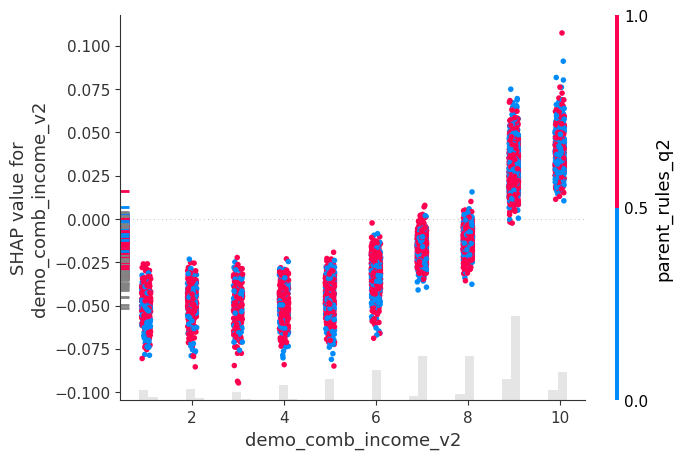

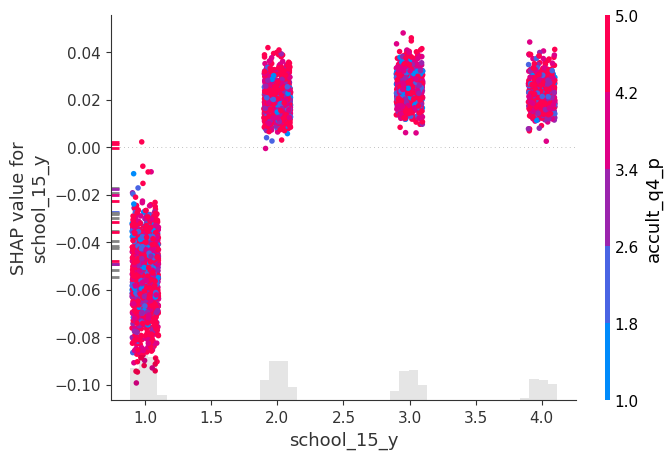

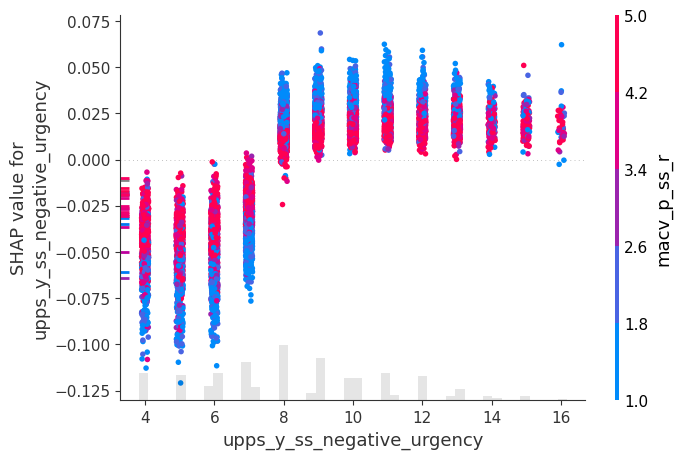

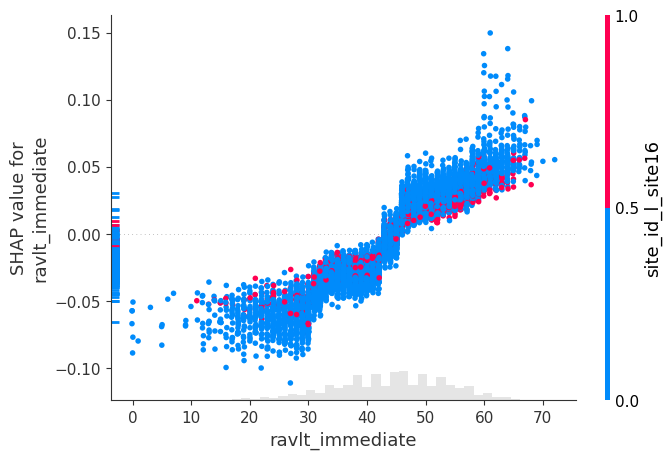

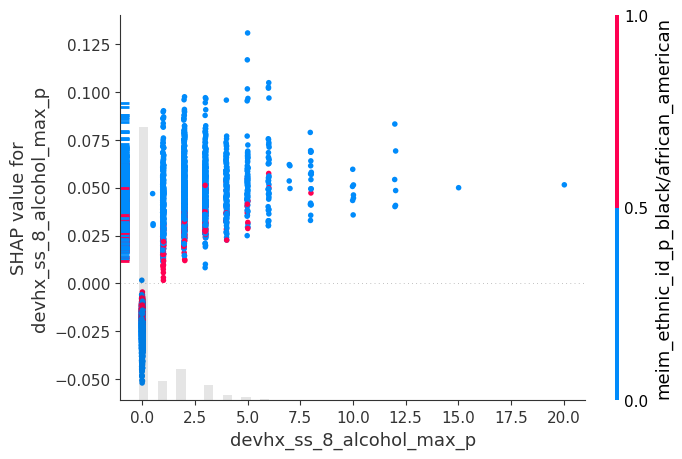

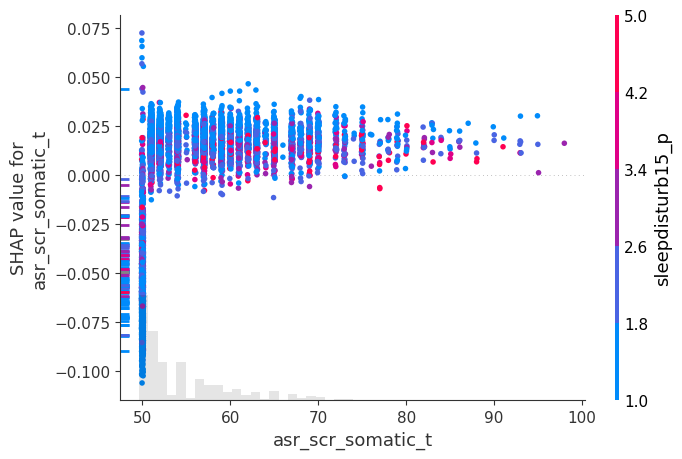

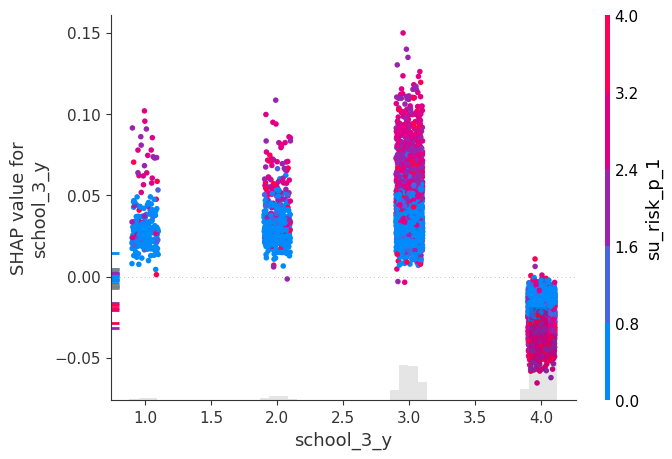

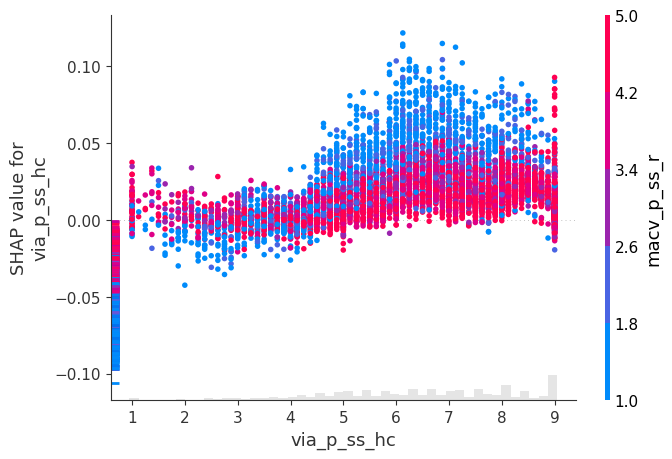

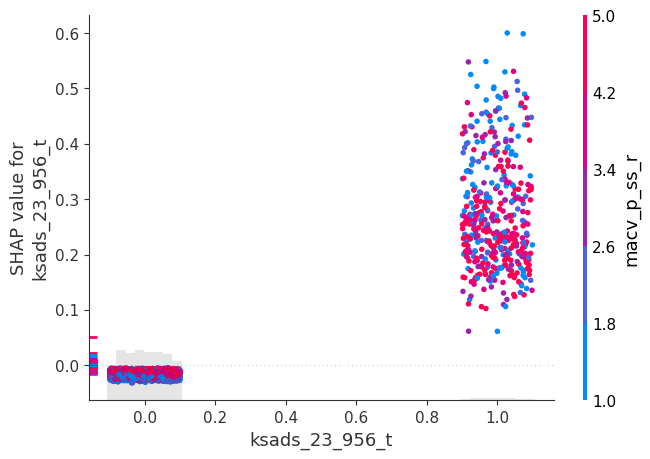

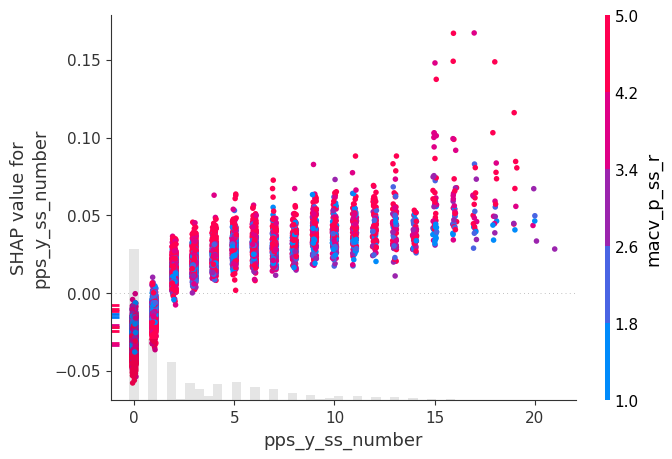

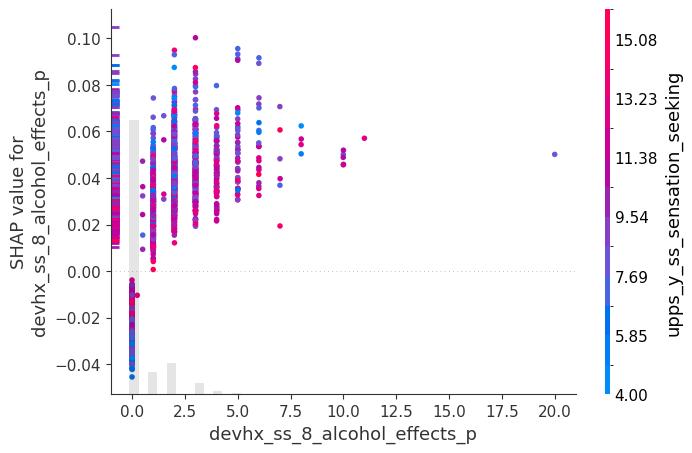

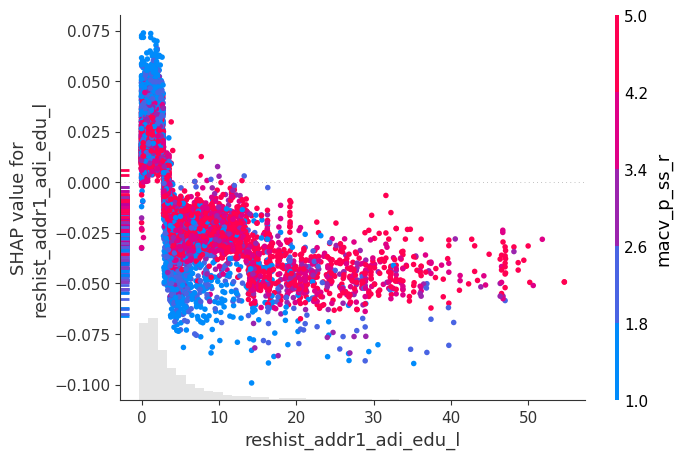

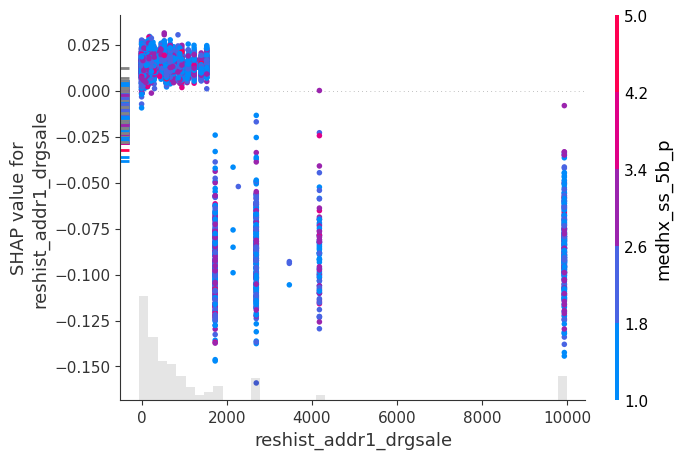

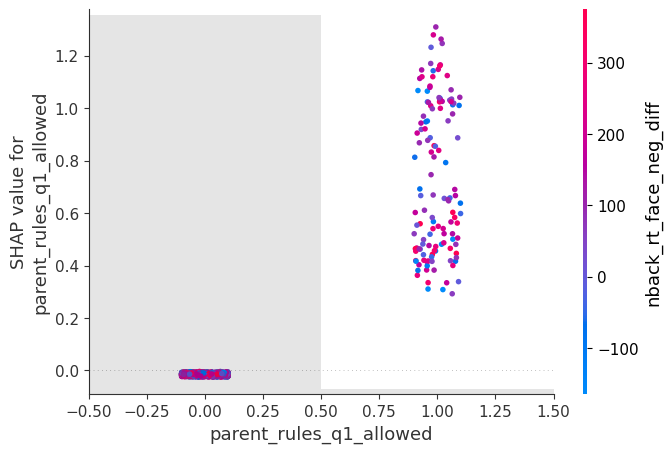

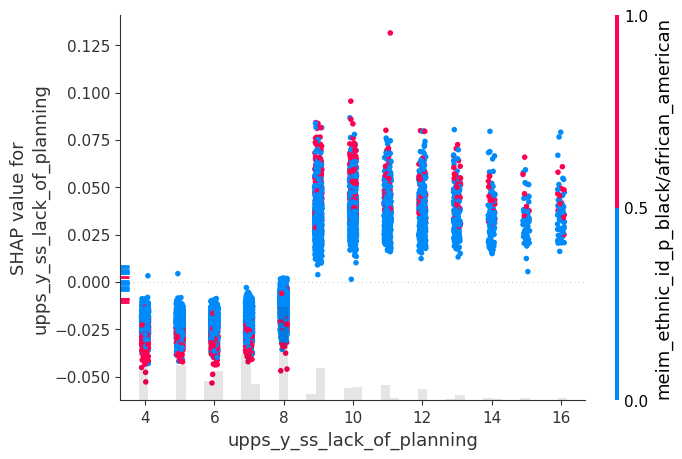

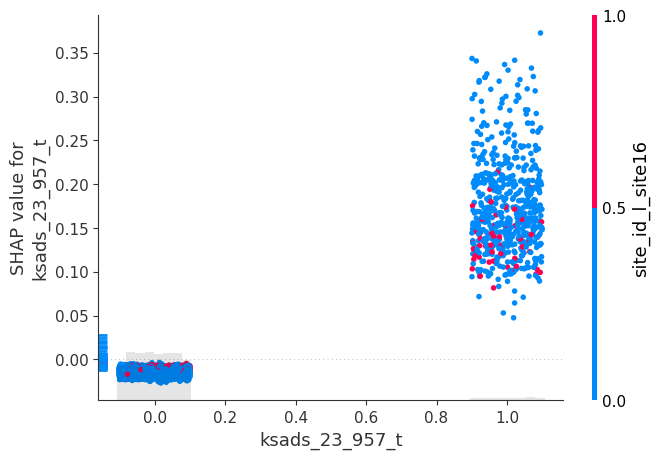

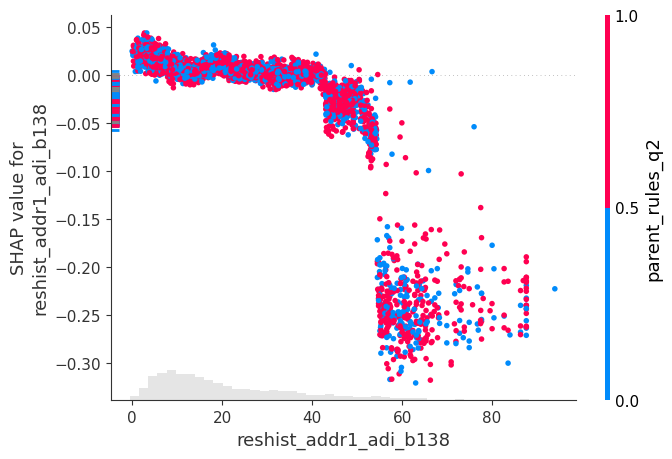

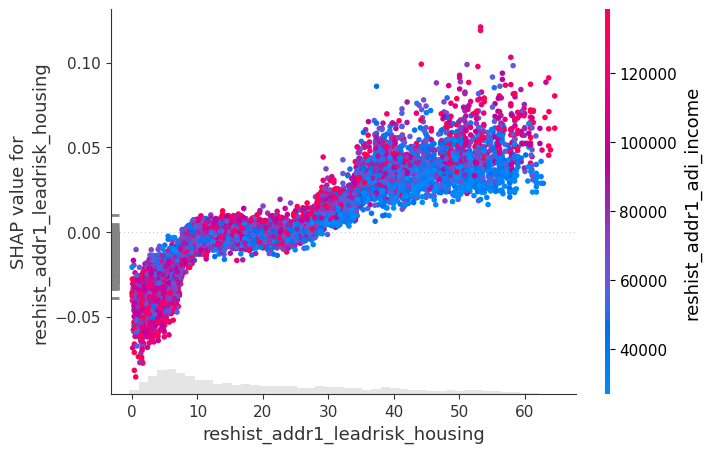

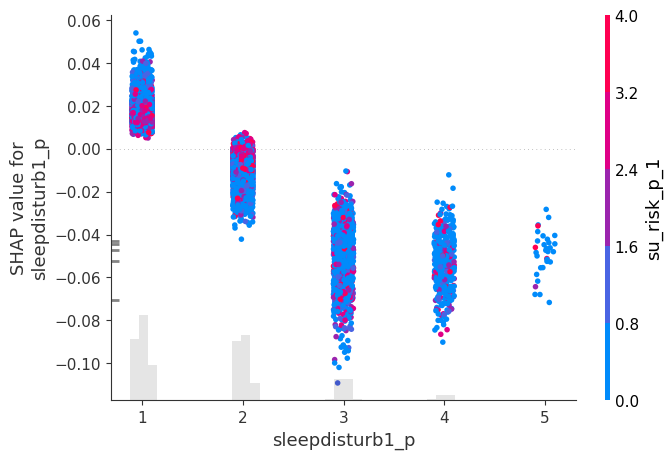

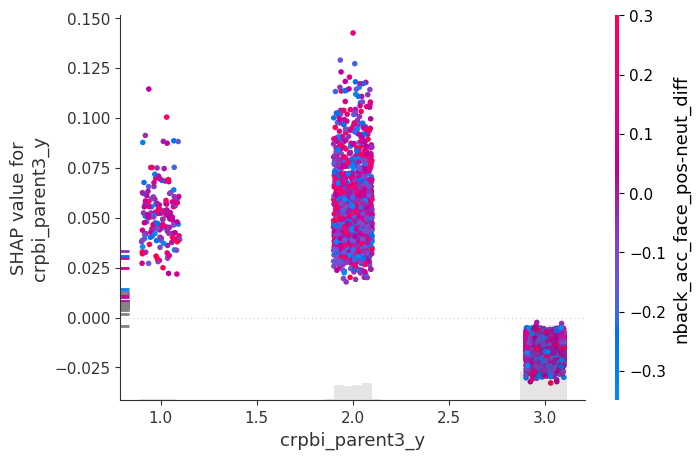

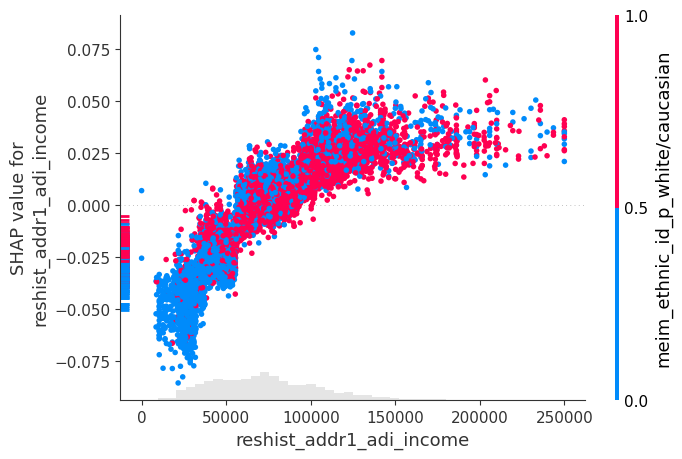

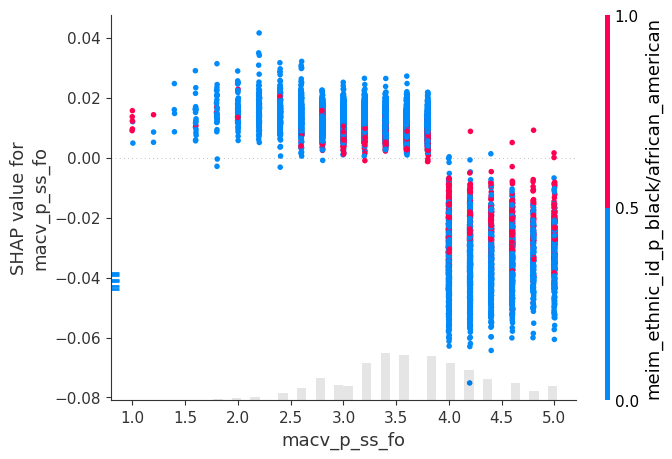

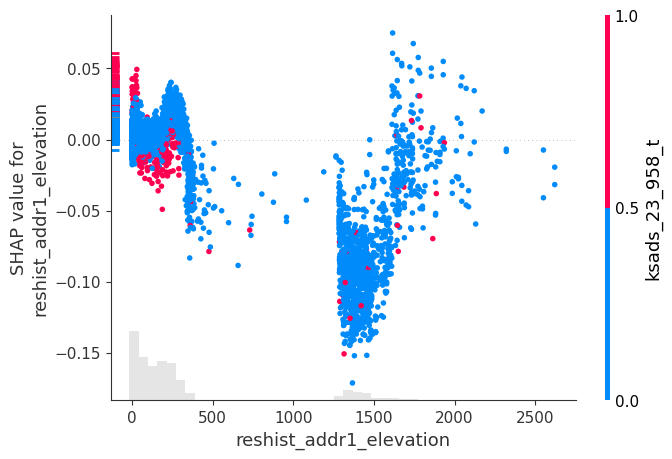

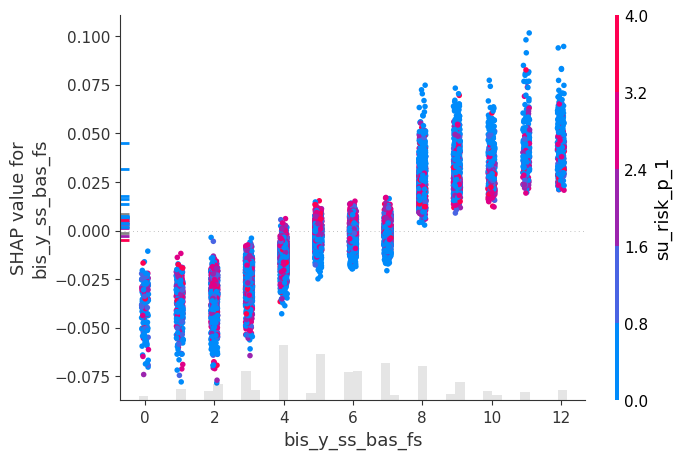

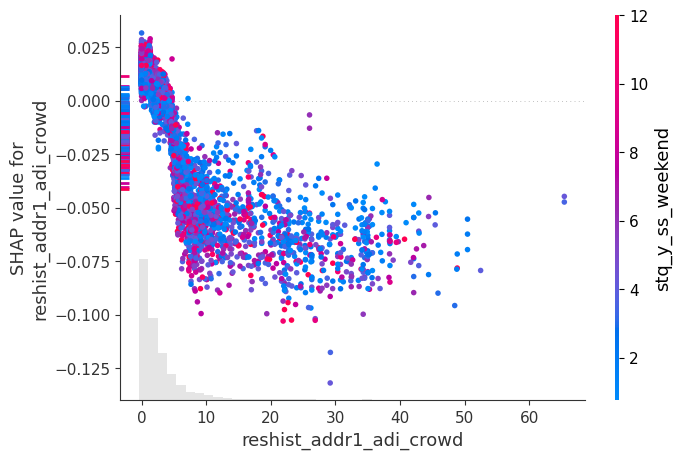

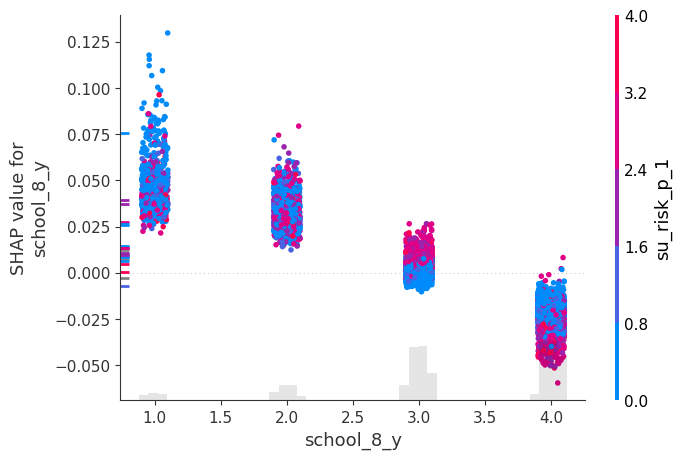

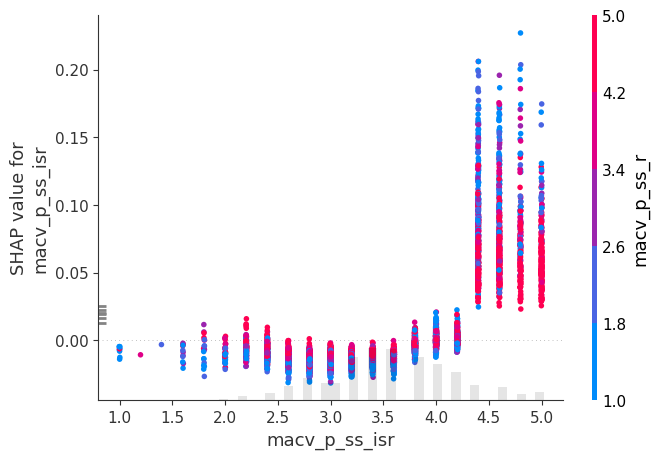

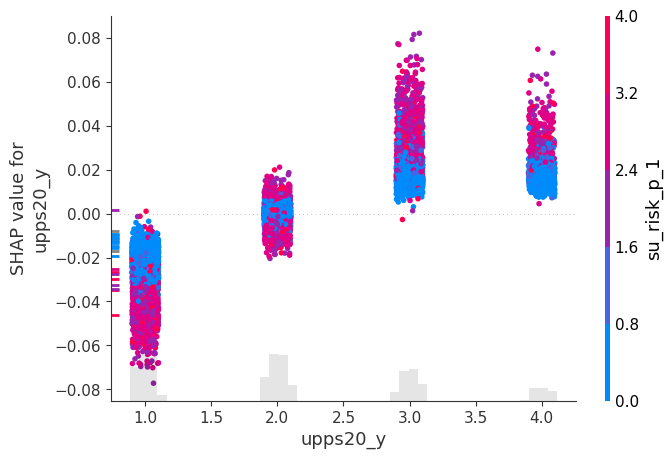

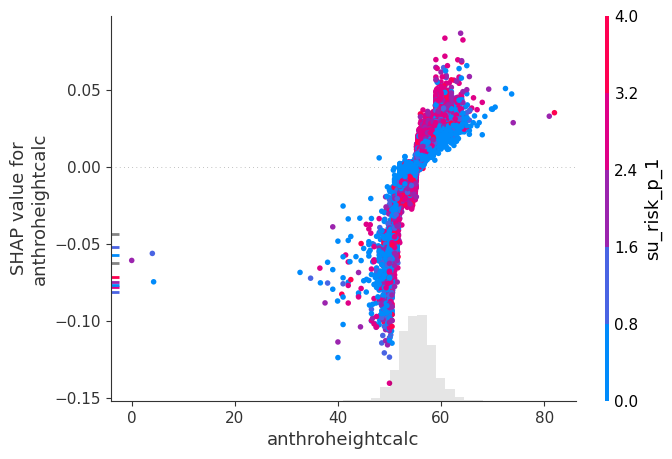

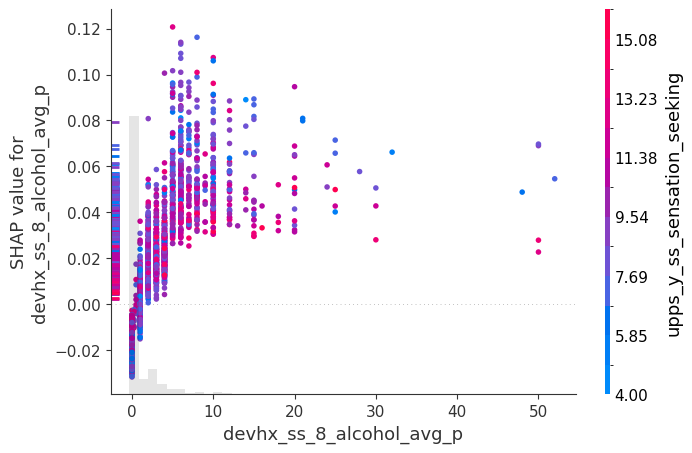

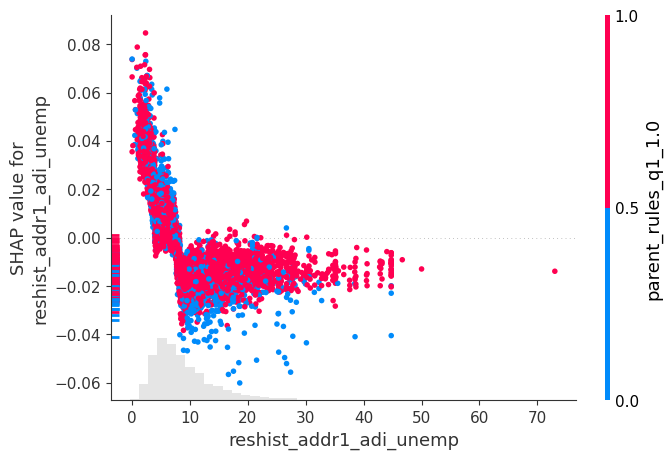

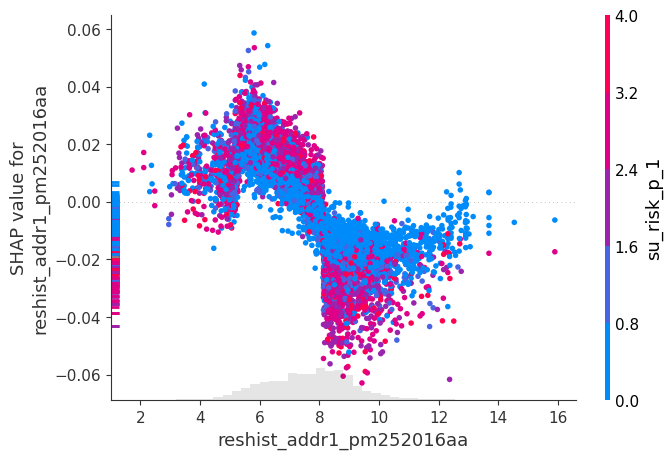

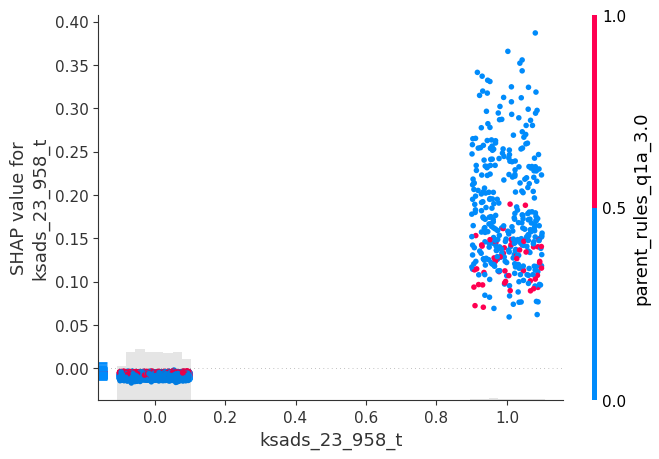

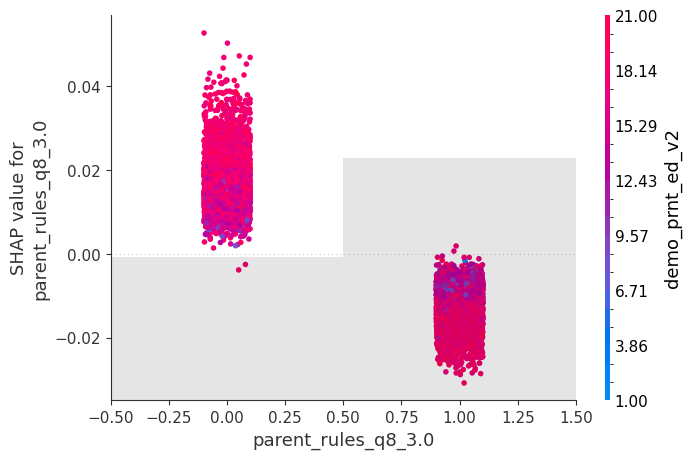

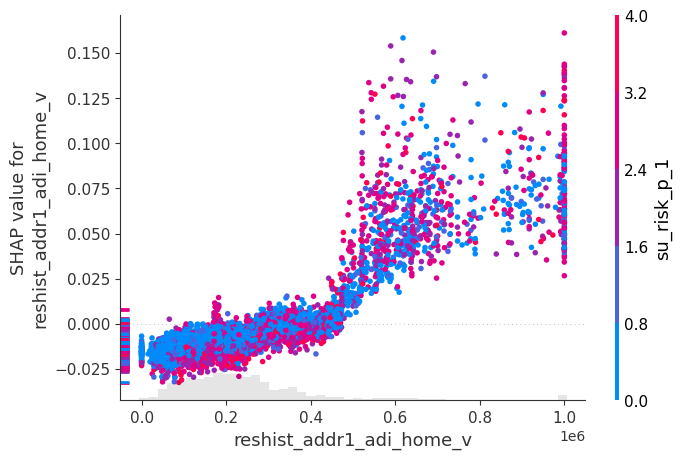

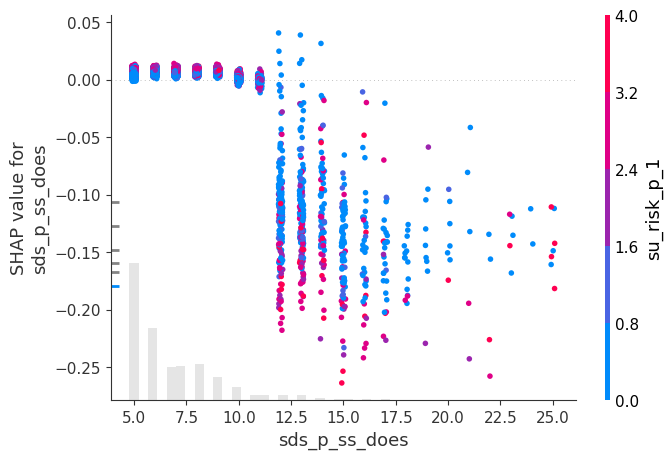

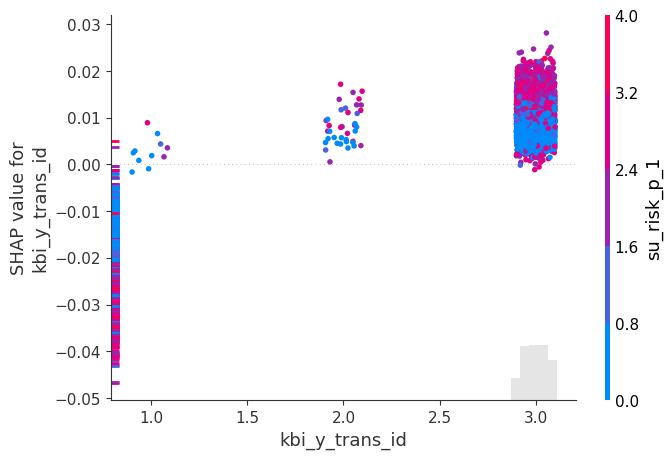

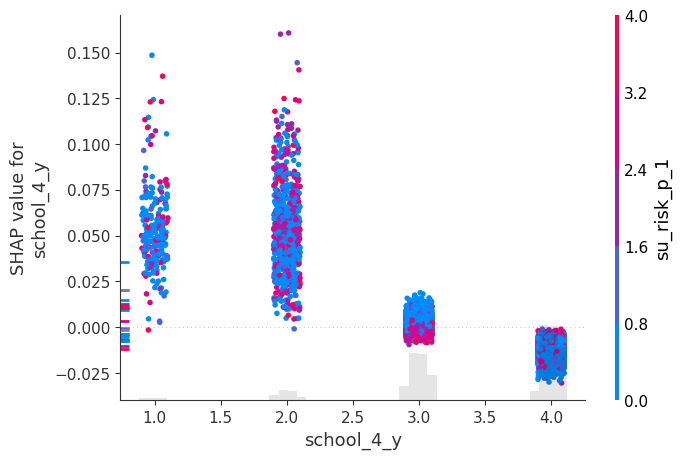

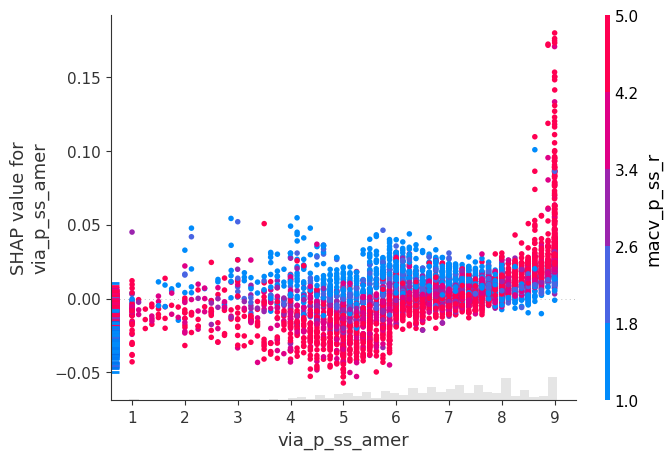

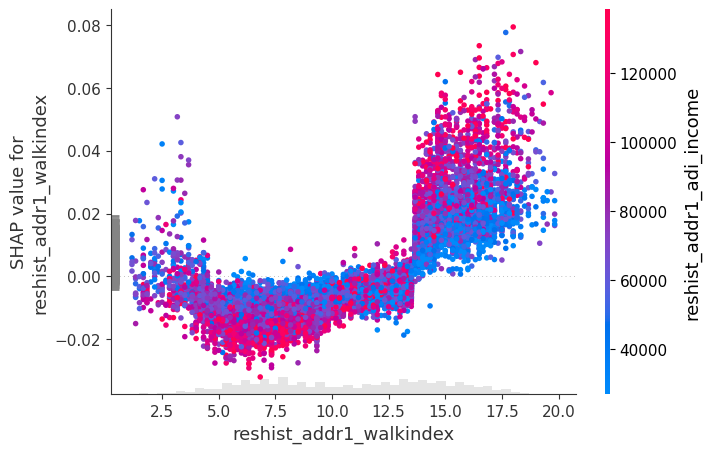

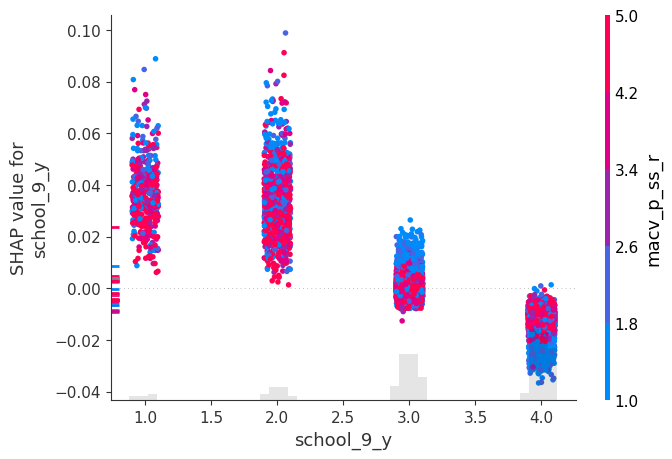

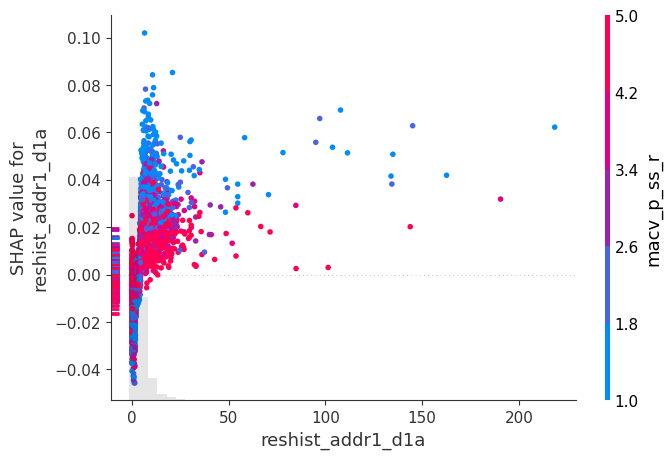

In [13]:
top_inds = np.argsort(-np.sum(np.abs(shap_values.values), 0))
for i in range(60):
    shap.plots.scatter(shap_values[:, top_inds[i]], color=shap_values)